In [5]:
import pickle
import numpy as np
import math

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

Modules loaded.


    labels[img_counter,1] = steering_angle;
    labels[img_counter,2] = throttle;
    labels[img_counter,3] = brake; 

In [6]:
# Normalize the data features to the variable X_normalized
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

# X_normalized = normalize_grayscale(X_train)

In [7]:
import matplotlib
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_image(image, caption, gray=False):
    plt.figure(figsize=(6,6))
    plt.tick_params(axis='x',labelbottom='off')
    plt.tick_params(axis='y',labelleft='off')
    if gray:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.title(caption)
    plt.show()

In [8]:
# rgb2yuv is only avaiable in version 0.13dev of scipy-image
import skimage
from skimage import color
from scipy import linalg

yuv_from_rgb = np.array([[ 0.299     ,  0.587     ,  0.114      ],
                         [-0.14714119, -0.28886916,  0.43601035 ],
                         [ 0.61497538, -0.51496512, -0.10001026 ]])

rgb_from_yuv = linalg.inv(yuv_from_rgb)

def rgb2yuv(rgb):
    return skimage.color.colorconv._convert(yuv_from_rgb, rgb)

def yuv2rgb(yuv):
    return skimage.color.colorconv._convert(rgb_from_yuv, yuv)

In [9]:
with open('/mnt/data/train_pretrain.p', 'rb') as f:
    data = pickle.load(f)

# Load the feature data to the variable X_train
X_train = data['features']
# Load the label data to the variable y_train
y_train = data['labels']
# Load additional features (velocity)
z_train = data['features_more']

In [10]:
# Number of training examples
n_train = len(X_train)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train)) # RAUS!

assert(len(X_train) == len(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 33
Image data shape = (64, 128, 3)
Number of classes = 22


In [11]:
# Shuffle the data
from sklearn.utils import shuffle
X_train, y_train, z_train = shuffle(X_train, y_train, z_train) 

In [12]:
def preprocess_img(img):
    img = img.astype(float)/255.0
    img = rgb2yuv(img) # convert to YUV colorspace
    img[:,:,0] = img[:,:,0] - 0.5; # remove mean
    return img

X_train_norm = np.empty_like(X_train, dtype='float32')
for index in range(len(X_train)):
    X_train_norm[index] = preprocess_img( X_train[index] )

print((X_train_norm.dtype))

float32


In [13]:
print(np.min(X_train_norm[:,:,:,0]), np.max(X_train_norm[:,:,:,0]))
print(np.min(X_train_norm[:,:,:,1]), np.max(X_train_norm[:,:,:,1]))
print(np.min(X_train_norm[:,:,:,2]), np.max(X_train_norm[:,:,:,2]))
assert math.isclose(np.min(X_train_norm), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_train_norm), 0.5, abs_tol=1e-5)

-0.5 0.5
-0.261585 0.175151
-0.1568 0.402122


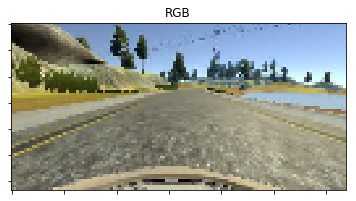

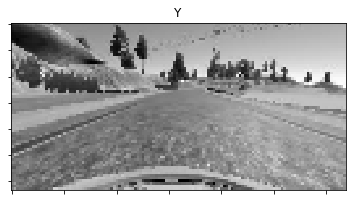

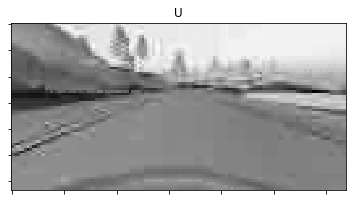

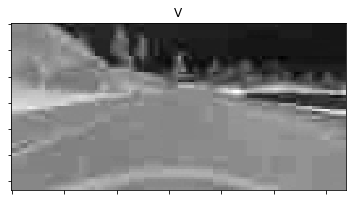

In [14]:
i = 3
plot_image(X_train[i]*-1, 'RGB', False)
plot_image(X_train_norm[i,:,:,0],'Y', True)
plot_image(X_train_norm[i,:,:,1],'U', True)
plot_image(X_train_norm[i,:,:,2],'V', True)

In [15]:
y_train_norm = y_train[:,0]
print( "min = {}, mean = {}, max = {}".format( np.min(y_train_norm), np.mean(y_train_norm), np.max(y_train_norm) ) )

min = -0.9426954, mean = 0.06114973636363636, max = 1.0


# Build Keras model

![logo](./images/NVIDIA_architecture.png)
We use strided convolutions in the
first three convolutional layers with a 2x2 stride and a 5x5 kernel and a non-strided convolution
with a 3x3 kernel size in the last two convolutional layers.

https://arxiv.org/pdf/1511.07289v1.pdf

In [16]:
# Build a model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.core import Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

In [27]:
def model_nvidia():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, input_shape=(64, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    #model.add(Convolution2D(36, 5, 5))
    #model.add(MaxPooling2D((2, 2)))
    #model.add(Activation('relu'))

    #model.add(Convolution2D(48, 5, 5))
    #model.add(MaxPooling2D((2, 2)))
    #model.add(Activation('relu'))

    #model.add(Convolution2D(64, 3, 3))
    #model.add(Activation('relu'))
    #model.add(ELU())

    #model.add(Convolution2D(64, 3, 3))
    #model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dropout(0.5))
    model.add(Activation('elu'))
    model.add(Dense(100))
    model.add(Activation('elu'))
    model.add(Dense(50))
    model.add(Activation('elu'))
    model.add(Dense(10))
    model.add(Activation('elu'))
    model.add(Dense(1))

    # Compile and train the model
    model.compile('adam', 'mse')
    return model

In [58]:
def model_commaAI():
#    ch, row, col = 3, 160, 320  # camera format
    ch, row, col = 3, 64, 128  # camera format
    use_dropout = True

    model = Sequential()
#    model.add(Lambda(lambda x: x,
#            input_shape=(row, col, ch),
#           output_shape=(row, col, ch)))
#    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))    
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape=(row, col, ch)))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    if use_dropout:
        model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    if use_dropout:    
        model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

In [59]:
#model = model_nvidia()
model = model_commaAI()
history = model.fit(X_train_norm, y_train_norm, nb_epoch=200, validation_split=0.0)

Epoch 1/200
33/33 [==============================] - 0s - loss: 0.4207     
Epoch 2/200
33/33 [==============================] - 0s - loss: 0.1664     
Epoch 3/200
33/33 [==============================] - 0s - loss: 0.2393     
Epoch 4/200
33/33 [==============================] - 0s - loss: 0.0947     
Epoch 5/200
33/33 [==============================] - 0s - loss: 0.1708     
Epoch 6/200
33/33 [==============================] - 0s - loss: 0.0769     
Epoch 7/200
33/33 [==============================] - 0s - loss: 0.0816     
Epoch 8/200
33/33 [========

30/33 [==========================>...] - ETA: 0s

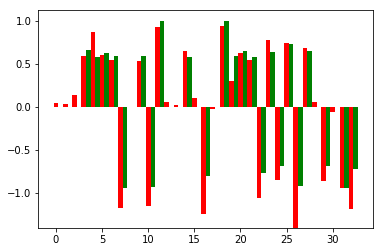

In [57]:
pred_steering = model.predict(X_train_norm, batch_size=1, verbose=1).squeeze()


fig, ax = plt.subplots()
ind = np.array(range(len(y_train_norm)));
width = 0.5;
ax.bar(ind, pred_steering, width, color='r')
ax.bar(ind + width, y_train_norm, width, color='g')
plt.show()

Predicted steering: 0.007 (correct 0.000)


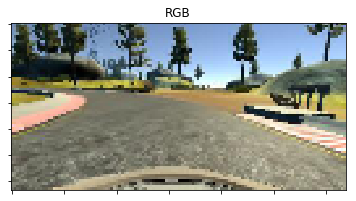

Predicted steering: -0.009 (correct 0.000)


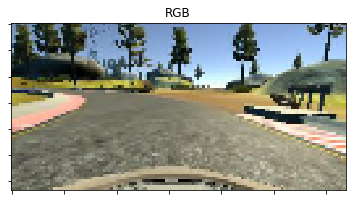

Predicted steering: 0.108 (correct 0.000)


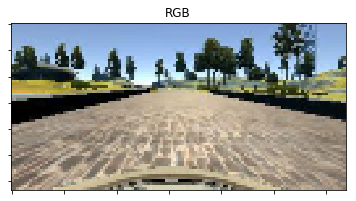

Predicted steering: 0.660 (correct 0.655)


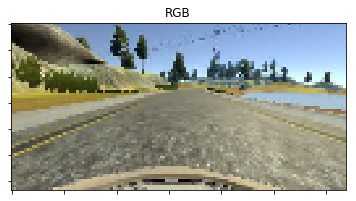

Predicted steering: 0.564 (correct 0.578)


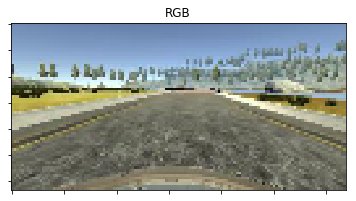

Predicted steering: 0.634 (correct 0.626)


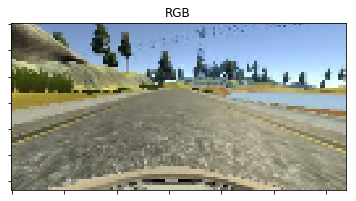

Predicted steering: 0.502 (correct 0.588)


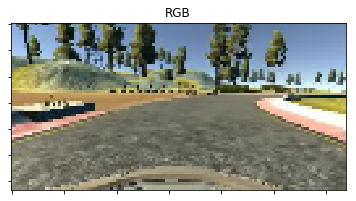

Predicted steering: -0.903 (correct -0.943)


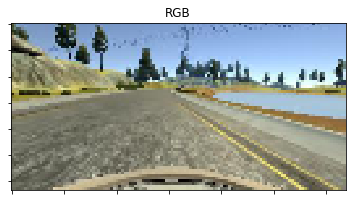

Predicted steering: 0.009 (correct 0.000)


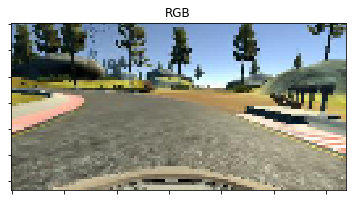

Predicted steering: 0.543 (correct 0.588)


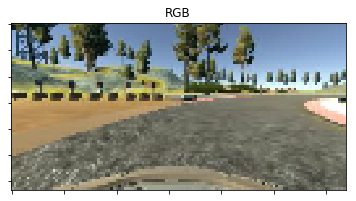

In [48]:
for i in range(10):
    print( "Predicted steering: %.3f (correct %.3f)" % ( pred_steering[i], y_train_norm[i] ) )
    plot_image(X_train[i]*-1, 'RGB', False)

In [ ]:
  model.add(BatchNormalization())
    
    model.add(Convolution2D(16, 5, 5, subsample=(4, 4), border_mode="same")
    model.add(Activation('relu')())
    model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode="same")
    model.add(Activation('relu')())
    model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same")
              
    #model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Convolution2D(24, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    #model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Convolution2D(36, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    #model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Convolution2D(48, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dense(10))
    model.add(ELU())
model.add(Dense(1))
        
model.add(Flatten())

In [ ]:
1/0
assert history.history['acc'][-1] > 0.92, 'The training accuracy was: %.3f. It shoud be greater than 0.92' % history.history['acc'][-1]
assert history.history['val_acc'][-1] > 0.85, 'The validation accuracy is: %.3f. It shoud be greater than 0.85' % history.history['val_acc'][-1]
print('Tests passed.')

In [ ]:
# TODO: Load test data
with open('test.p', 'rb') as f:
    data_test = pickle.load(f)

X_test = data_test['features']
y_test = data_test['labels']

# TODO: Preprocess data & one-hot encode the labels
X_normalized_test = normalize_grayscale(X_test)
y_one_hot_test = label_binarizer.fit_transform(y_test)

# TODO: Evaluate model on test data
metrics = model.evaluate(X_normalized_test, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))